# Define model validation metrics

In [2]:
import os
import h5py
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil
from pathlib import Path
from toolz import valmap
from tqdm.auto import tqdm
from aging.size_norm.lightning import SizeNormModel
# below is necessary for now, might not need in future iterations
from aging.size_norm.data import normalize, clean, unnormalize
from toolz import keyfilter

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import r2_score

In [3]:
torch.set_num_threads(int(os.environ.get("SLURM_CPUS_PER_TASK", 1)))

## Apply model to validation data

In [4]:
scan_results = pd.read_parquet('/n/groups/datta/win/longtogeny/data/size_network/analysis/param_scan_04_results.parquet')

In [7]:
options = scan_results.query('arch == "unet" & depth == 4')

In [8]:
options.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 26 to 38
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   depth            4 non-null      int64  
 1   arch             4 non-null      object 
 2   channel_scaling  4 non-null      float64
 3   depth_scaling    4 non-null      float64
 4   init_depth       4 non-null      int64  
 5   init_channel     4 non-null      int64  
 6   mse              4 non-null      float64
 7   train_mse        4 non-null      float64
 8   epoch            4 non-null      int64  
 9   heldout_beh_val  4 non-null      float64
 10  fit_beh_val      4 non-null      float64
 11  param_count      4 non-null      float64
 12  file             4 non-null      object 
dtypes: float64(7), int64(4), object(2)
memory usage: 448.0+ bytes


In [9]:
mdl = torch.jit.load(options['file'].iloc[0], map_location='cpu')

In [3]:
# model_path = Path('/n/groups/datta/win/longtogeny/size_norm/models/ae/ae-epoch=0026-val_loss=4.79e-04.ckpt')
# model_path = Path('/n/groups/datta/win/longtogeny/size_norm/models/unet/')
# model_path = sorted(model_path.glob('*.ckpt'))[-1]
model_path = Path('/n/groups/datta/win/longtogeny/size_norm/models/param_scan/bc632741-9de6-44bf-8b3c-e10e835948f8/Autoencoder-epoch=73-val_loss=5.84e-04.ckpt')

In [15]:
model_path

PosixPath('/n/groups/datta/win/longtogeny/size_norm/models/param_scan/bc632741-9de6-44bf-8b3c-e10e835948f8/Autoencoder-epoch=73-val_loss=5.84e-04.ckpt')

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SizeNormModel.load_from_checkpoint(model_path, map_location=torch.device(device))
model.eval()
model.freeze();

In [17]:
max_frames = 4_000


# apply the model to batches of data
def batch_gen(datasize, batch_size):
    for i in range(0, datasize, batch_size):
        yield i, min(i + batch_size, datasize)


data = {}
preds = {}

val_data_path = Path(
    "/n/groups/datta/win/longtogeny/data/size_network/female_ontogeny_validation.h5"
)
with h5py.File(val_data_path, "r") as h5f, torch.no_grad():
    for key in tqdm(h5f["data"]):
        data[key] = h5f["data"][key][:max_frames]

        yhat = []
        for start, stop in tqdm(
            batch_gen(max_frames, 256), desc="Batches", total=ceil(max_frames / 256)
        ):
            _in = normalize(
                torch.from_numpy(data[key][start:stop]).unsqueeze(1).float()
            ).to(device)
            yhat.append(unnormalize(model(_in).cpu().squeeze().numpy()))
        preds[key] = np.concatenate(yhat, axis=0)

  0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

In [18]:
preds = valmap(lambda v: np.where(v < 1, 0, v), preds)

In [19]:
list(preds)

['session_20221007115404_3wks',
 'session_20221007131716_3wks',
 'session_20221011093457_3months',
 'session_20221011144152_3months',
 'session_20221013093552_18months',
 'session_20221013115640_18months',
 'session_20221018110522_12months',
 'session_20221018114703_12months',
 'session_20221020114522_5wks',
 'session_20221020122457_5wks',
 'session_20221021114437_7wks',
 'session_20221021131235_7wks',
 'session_20221027110024_6months',
 'session_20221027115005_6months',
 'session_20221028095422_9wks',
 'session_20221028111609_9wks']

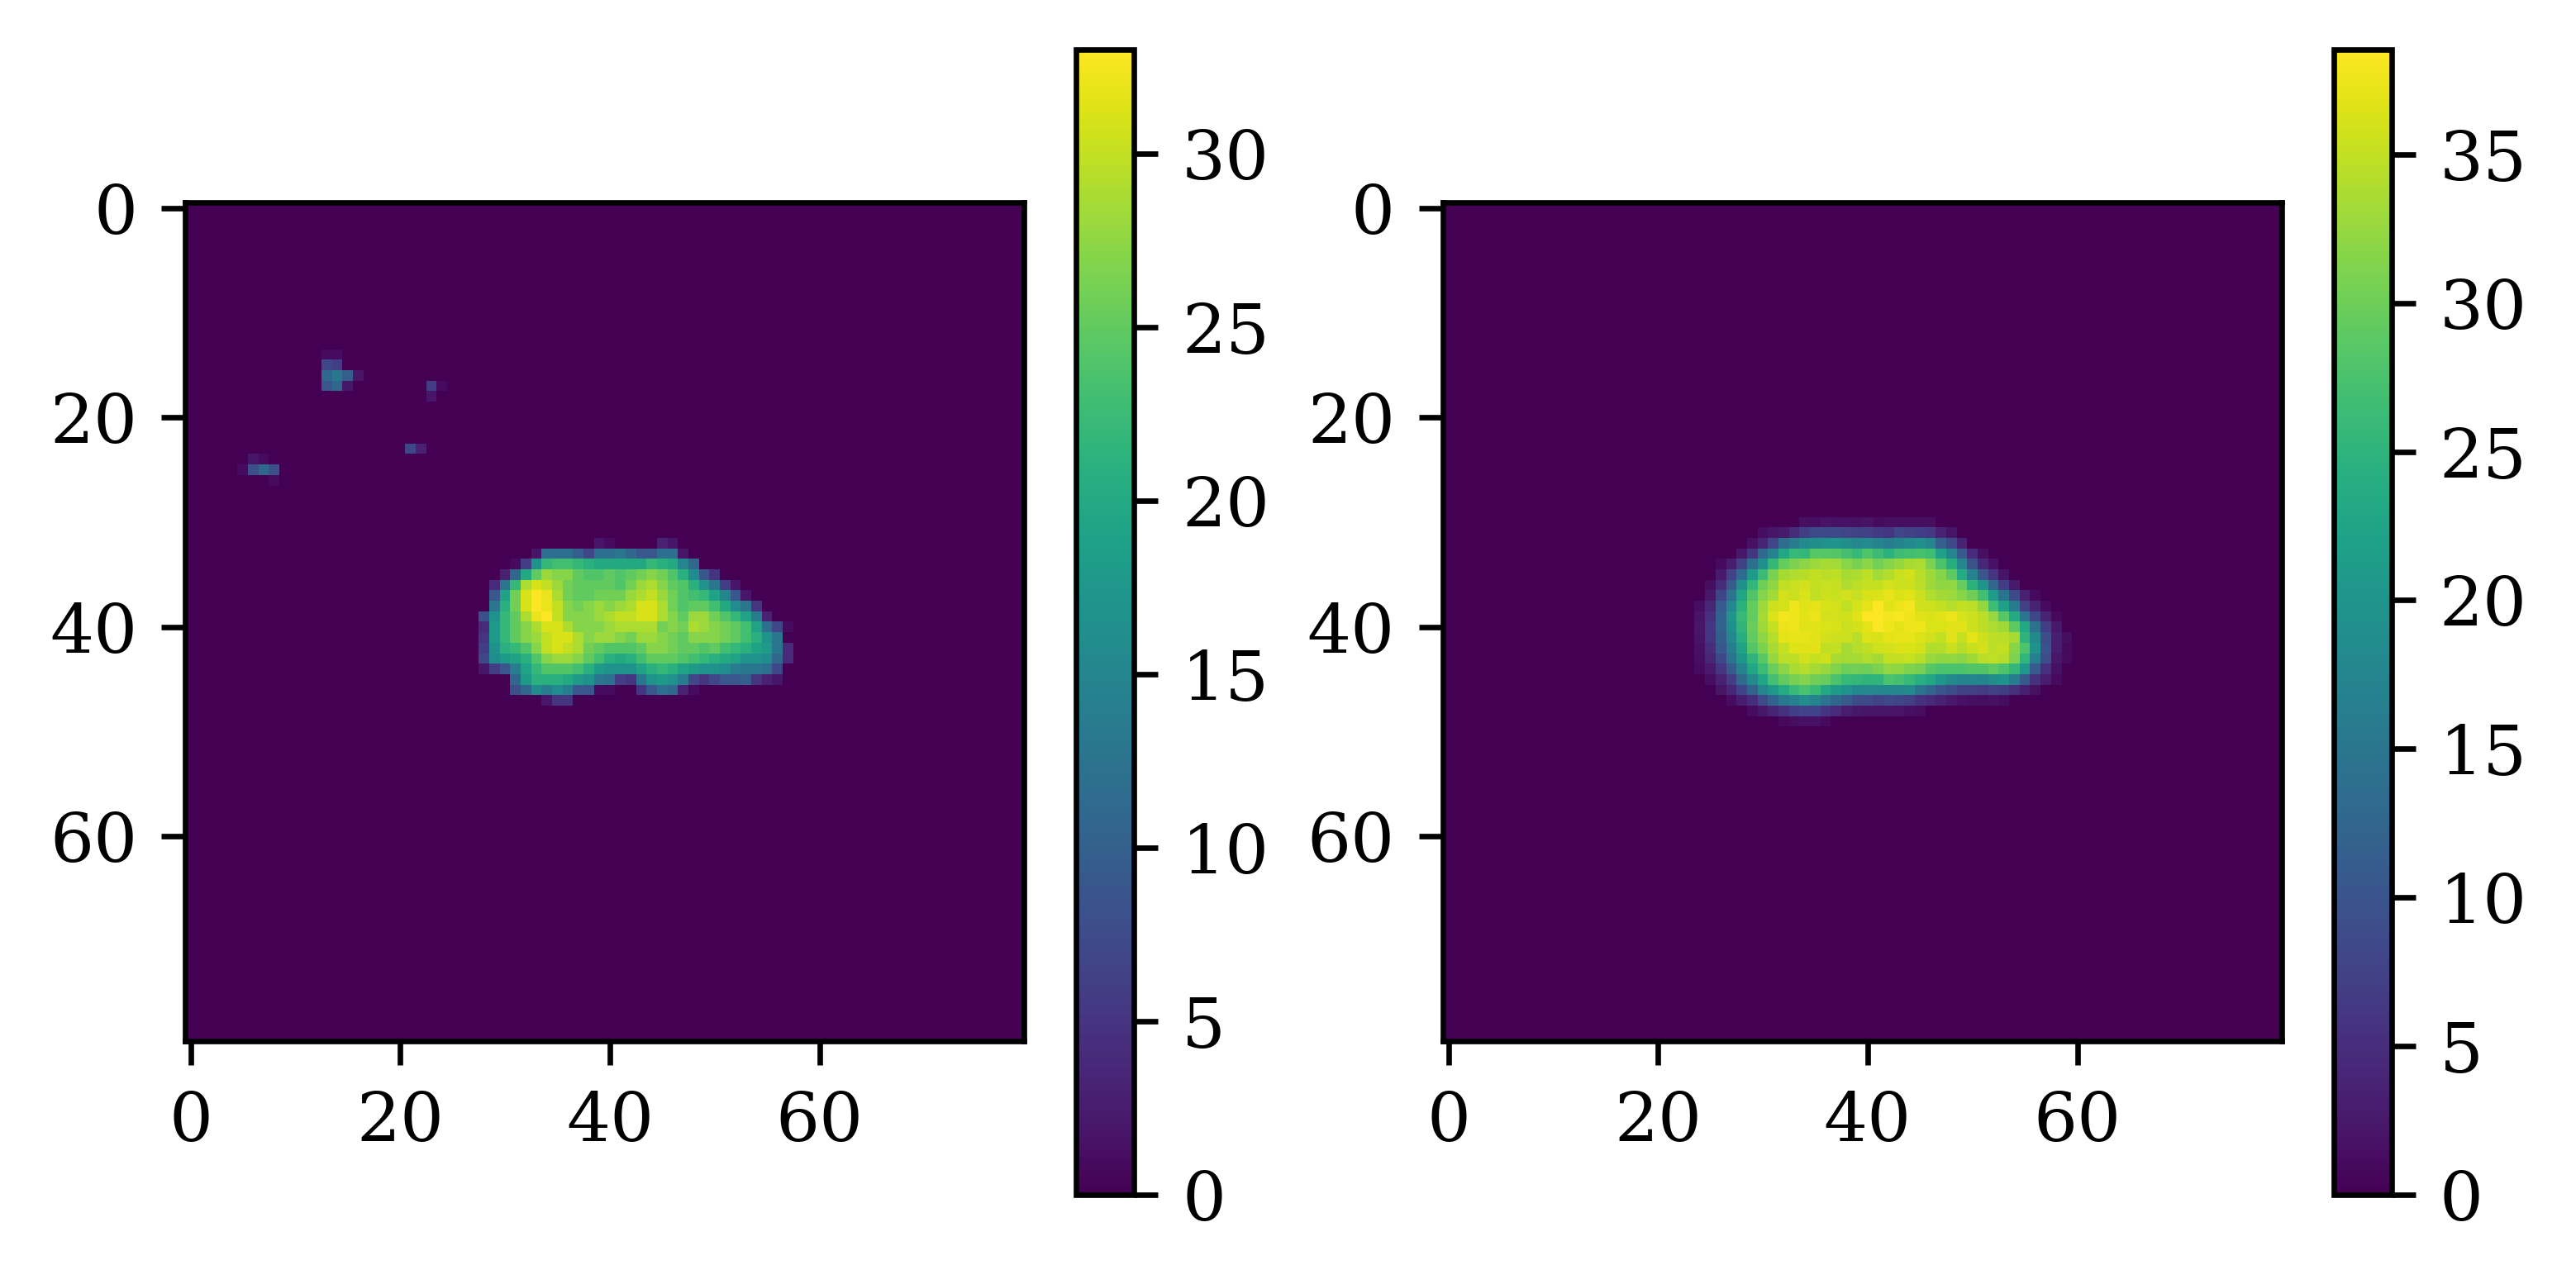

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
im = ax[0].imshow(data[list(preds)[0]][10])
fig.colorbar(mappable=im, ax=ax[0])
im = ax[1].imshow(preds[list(preds)[0]][10])
fig.colorbar(mappable=im, ax=ax[1])

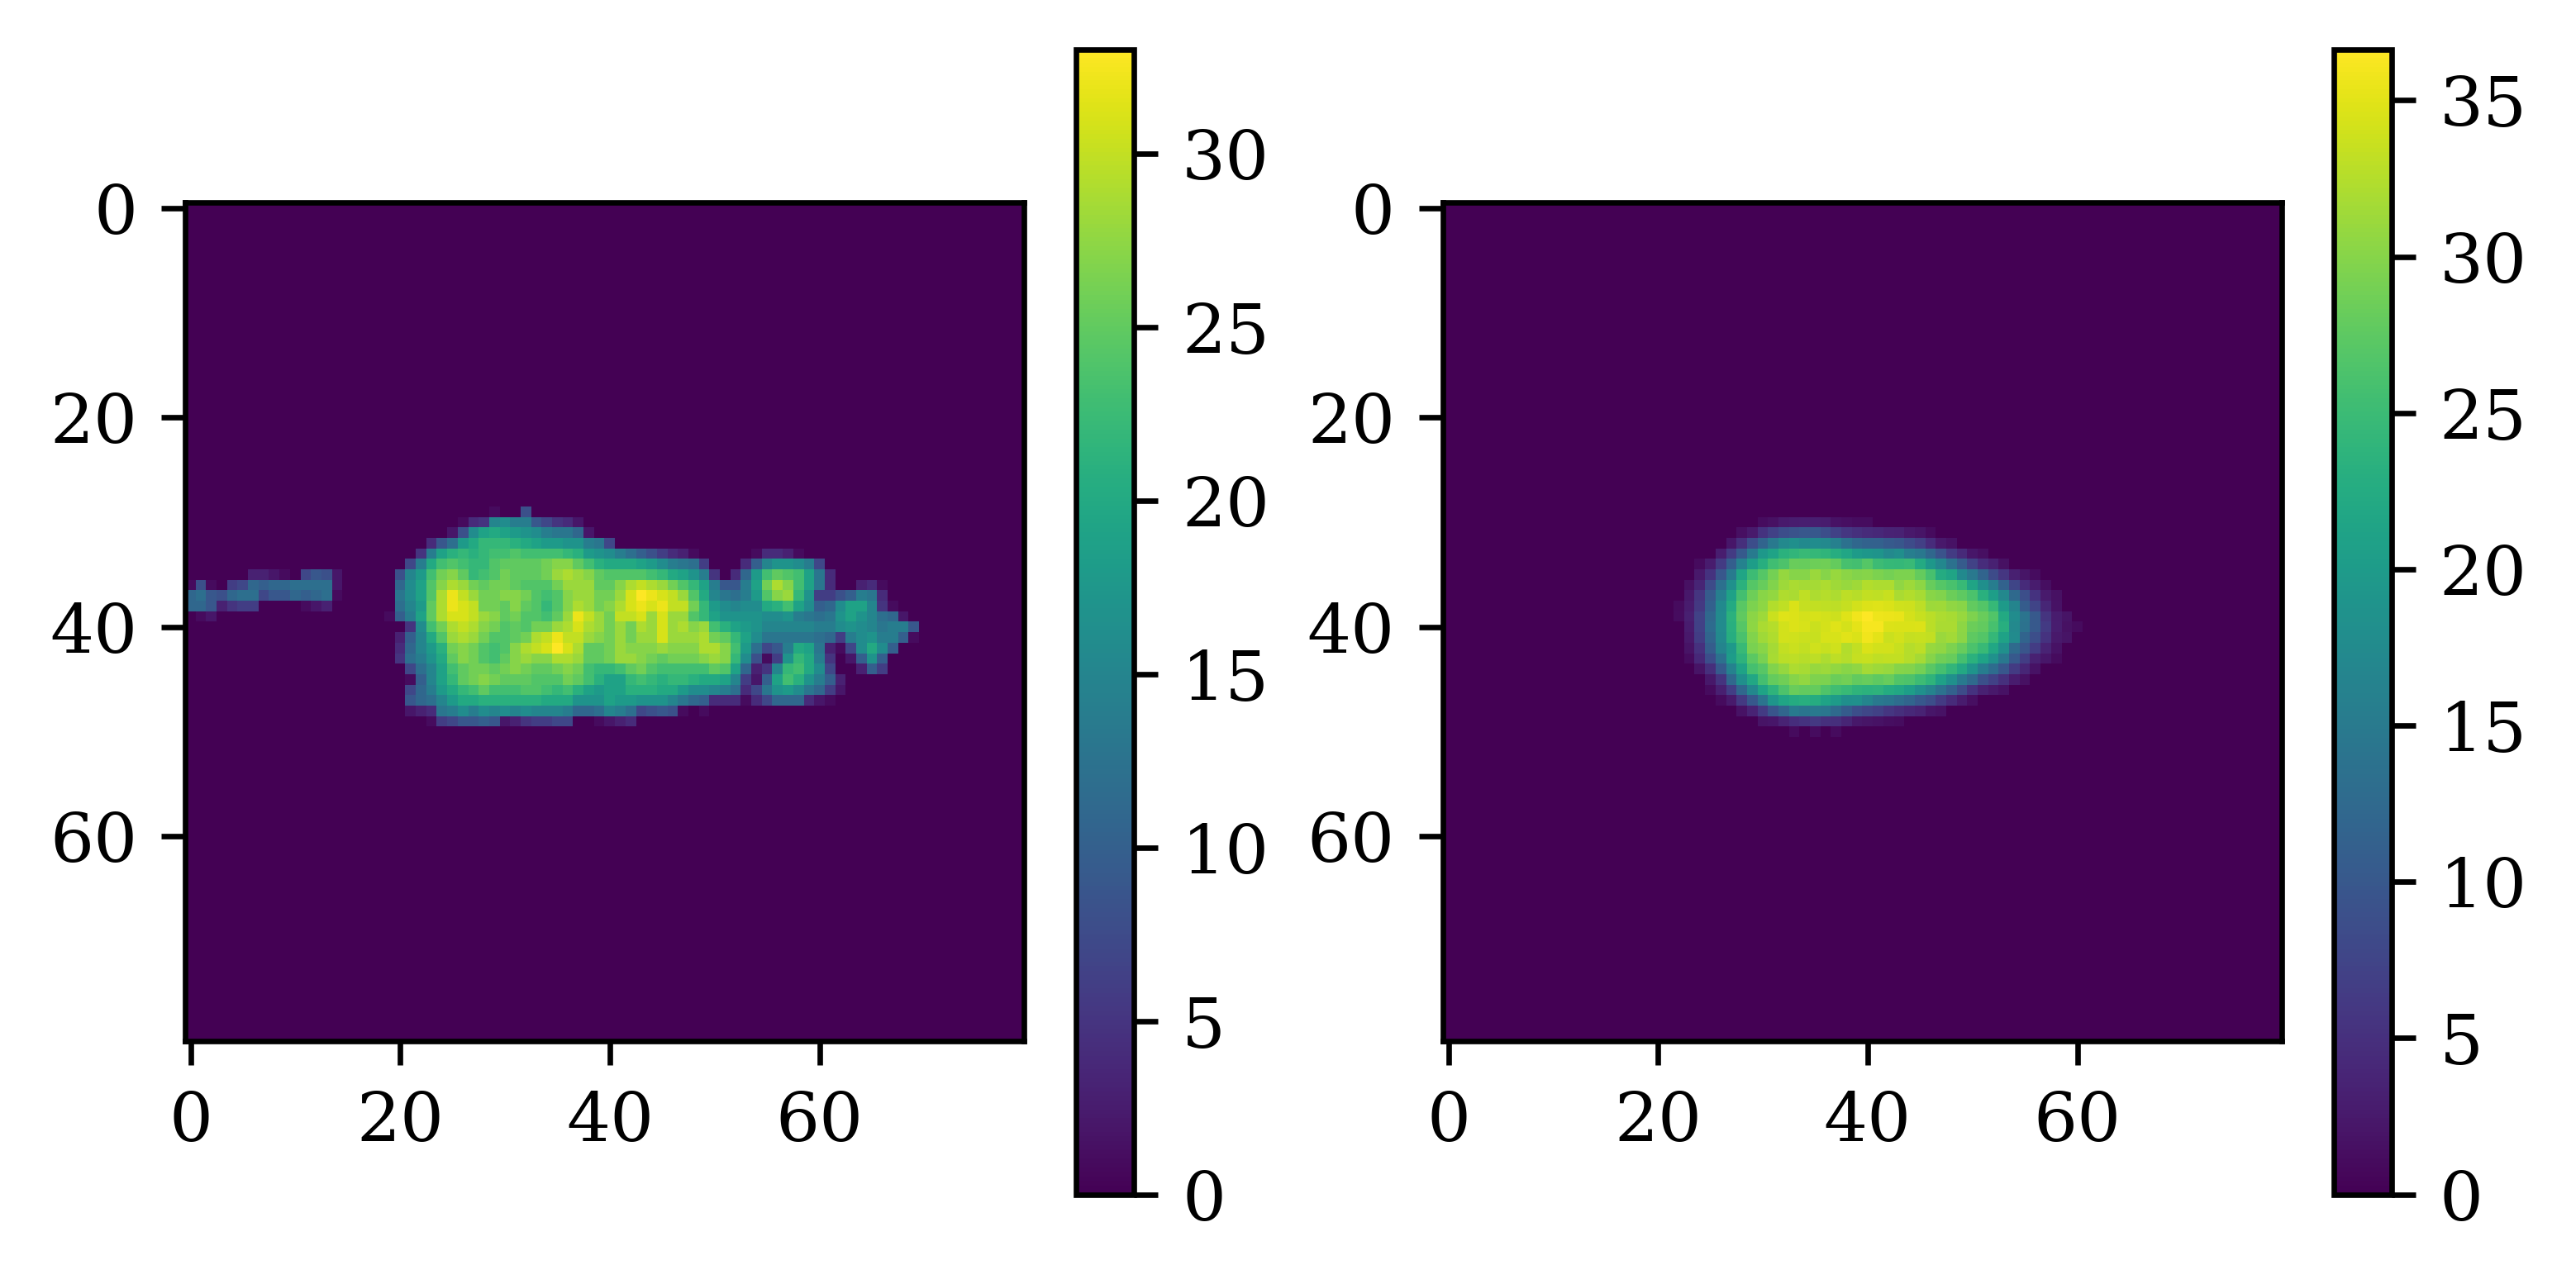

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
im = ax[0].imshow(data[list(preds)[4]][10])
fig.colorbar(mappable=im, ax=ax[0])
im = ax[1].imshow(preds[list(preds)[4]][10])
fig.colorbar(mappable=im, ax=ax[1])

## Mouse age classification

Classify age before and after applying model.
Start with logistic regression or random forest classifier.

In [22]:
pipeline = make_pipeline(
    PCA(n_components=15),
    StandardScaler(),
    LogisticRegression(max_iter=200)
    # RandomForestClassifier(n_estimators=100)
)

In [23]:
np.random.seed(0)
selection = valmap(lambda v: np.random.permutation(v)[:2000], data)
selection = valmap(lambda v: np.array(list(map(clean, v))), selection)

ages = []
train_data = []
for k, v in selection.items():
    ages.extend([k.split('_')[-1]] * len(v))
    train_data.append(v)
ages = np.array(ages)
train_data = np.concatenate(train_data, axis=0)

out = cross_val_score(
    pipeline,
    train_data.reshape(len(train_data), -1),
    ages,
    cv=StratifiedKFold(6),
    n_jobs=2
)
out

array([0.58173978, 0.57424072, 0.5792237 , 0.59572473, 0.59291206,
       0.58972436])

In [24]:
chance = 1 / len(np.unique(ages))
chance

0.125

In [25]:
np.random.seed(0)
pred_selection = valmap(lambda v: np.random.permutation(v)[:2000], preds)

ages = []
train_data = []
for k, v in pred_selection.items():
    ages.extend([k.split('_')[-1]] * len(v))
    train_data.append(v)
ages = np.array(ages)
train_data = np.concatenate(train_data, axis=0)

preds_out = cross_val_score(
    pipeline,
    train_data.reshape(len(train_data), -1),
    ages,
    cv=StratifiedKFold(6),
    n_jobs=2
)
preds_out

array([0.24484439, 0.23622047, 0.24132758, 0.24545284, 0.2383274 ,
       0.24076505])

### Compare to RW's model

In [26]:
rw_data_path = Path('/n/groups/datta/win/longtogeny/data/size_network/female_ontogeny_rw_preds.h5')

rw_data = {}
with h5py.File(rw_data_path, 'r') as h5f, torch.no_grad():
    for key in tqdm(h5f['data']):
        rw_data[key] = h5f['data'][key][:4_000]

np.random.seed(0)
rw_selection = valmap(lambda v: np.random.permutation(v)[:2000], rw_data)

  0%|          | 0/14 [00:00<?, ?it/s]

In [27]:
ages = []
train_data = []
for k, v in rw_selection.items():
    ages.extend([k.split('_')[-1]] * len(v))
    train_data.append(v)
ages = np.array(ages)
train_data = np.concatenate(train_data, axis=0)

rw_out = cross_val_score(
    pipeline,
    train_data.reshape(len(train_data), -1),
    ages,
    cv=StratifiedKFold(6),
    n_jobs=2
)
rw_out

array([0.36790229, 0.36018856, 0.36747375, 0.35590315, 0.34569224,
       0.35983712])

In [28]:
outcomes = dict(
    raw=out,
    transformed=preds_out,
    rw_transformed=rw_out,
)

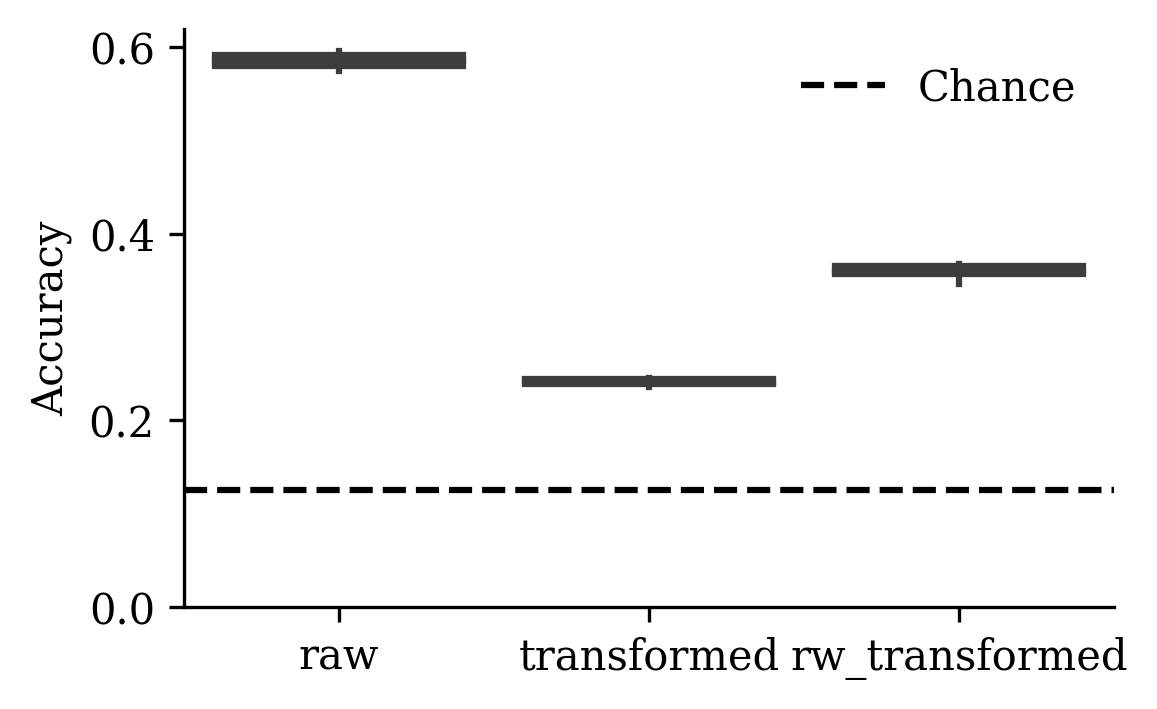

In [29]:
fig = plt.figure(figsize=(4, 2.5))
fig.dpi = 150
ax = sns.boxplot(data=pd.DataFrame(outcomes), showcaps=False)
plt.axhline(chance, color='k', ls='--', label='Chance')
ax.set(ylim=(0, None), ylabel='Accuracy')
plt.legend(frameon=False)
sns.despine()

## Compare size distributions before and after applying model

In [30]:
np.random.seed(0)
selection = valmap(lambda v: np.random.permutation(v)[:max_frames], data)
selection = valmap(lambda v: np.array(list(map(clean, v))), selection)

np.random.seed(0)
pred_selection = valmap(lambda v: np.random.permutation(v)[:max_frames], preds)

np.random.seed(0)
rw_selection = valmap(lambda v: np.random.permutation(v)[:max_frames], rw_data)

In [31]:
area = valmap(lambda v: np.median((v > 5).sum(axis=(1, 2))), selection)
pred_area = valmap(lambda v: np.median((v > 0.05).sum(axis=(1, 2))), pred_selection)
rw_area = valmap(lambda v: np.median((v > 5).sum(axis=(1, 2))), rw_selection)
areas = pd.DataFrame(dict(
    raw=keyfilter(lambda k: k in rw_area, area).values(),
    transformed=keyfilter(lambda k: k in rw_area, pred_area).values(),
    rw_transformed=rw_area.values()
), index=[k.split('_')[-1] for k in rw_area])

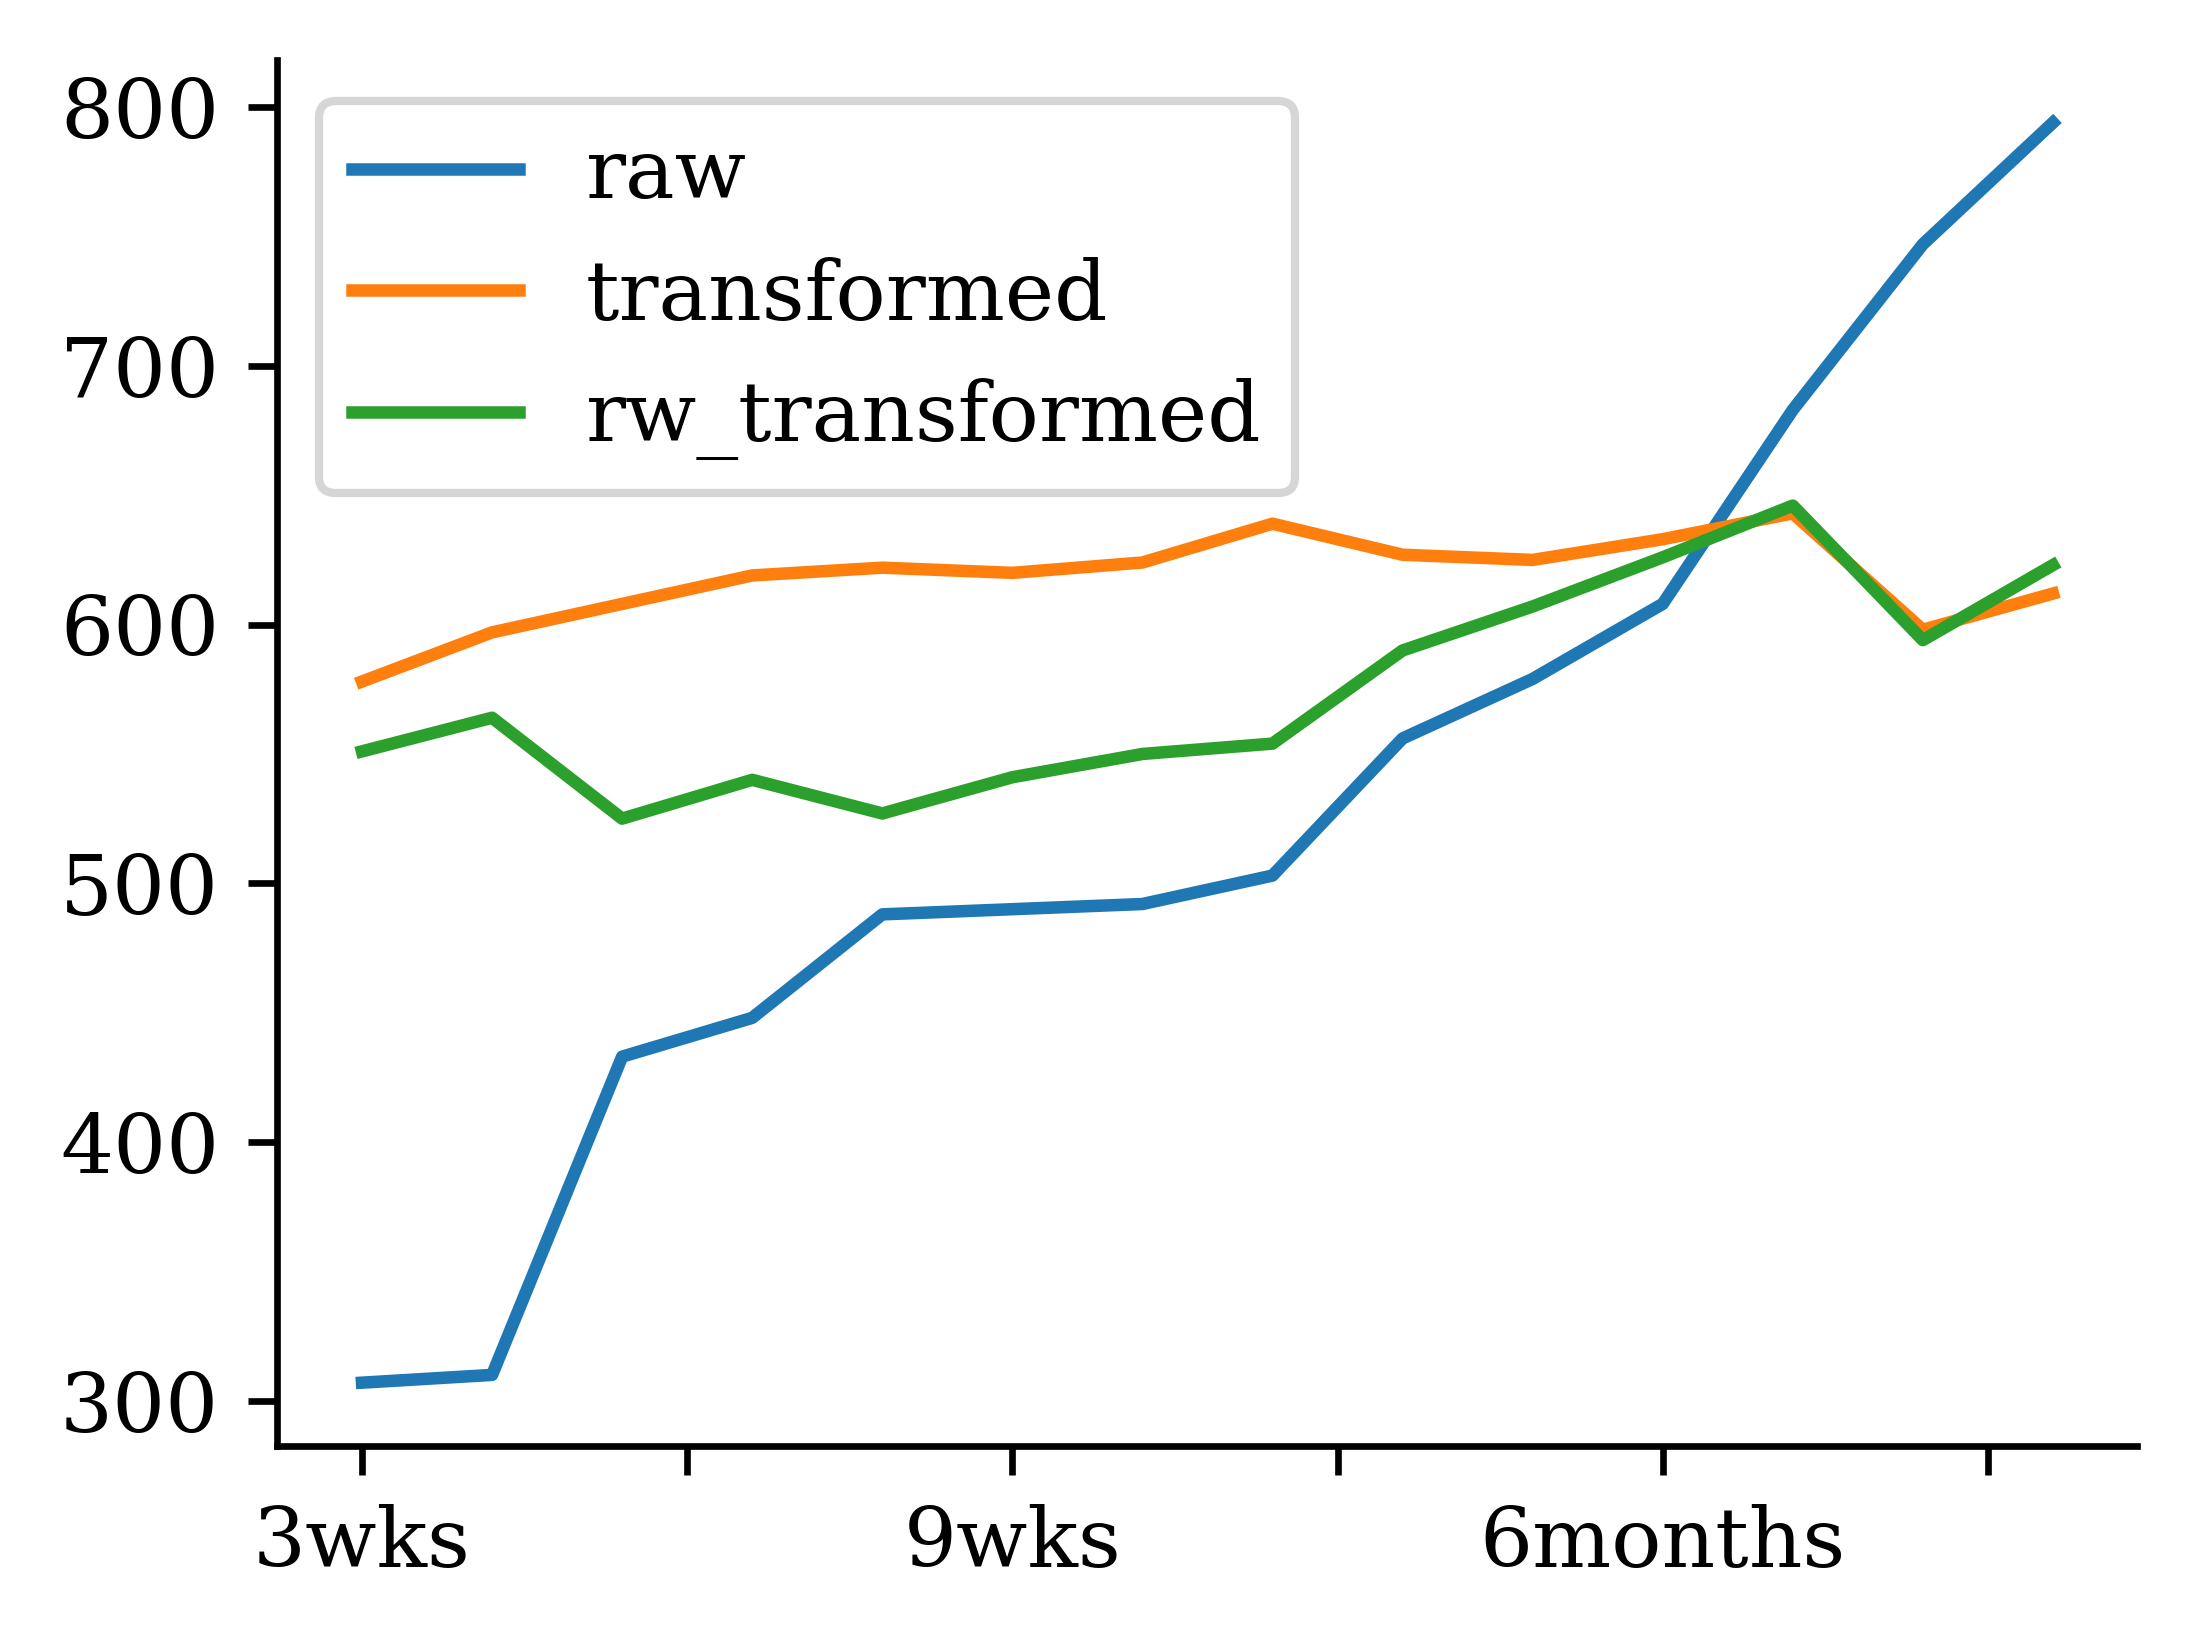

In [32]:
fig = areas.sort_values(by='raw').plot(figsize=(4, 3))
fig.dpi = 100
sns.despine()

In [33]:
areas.std()

raw               143.883194
transformed        17.653720
rw_transformed     39.704402
dtype: float64

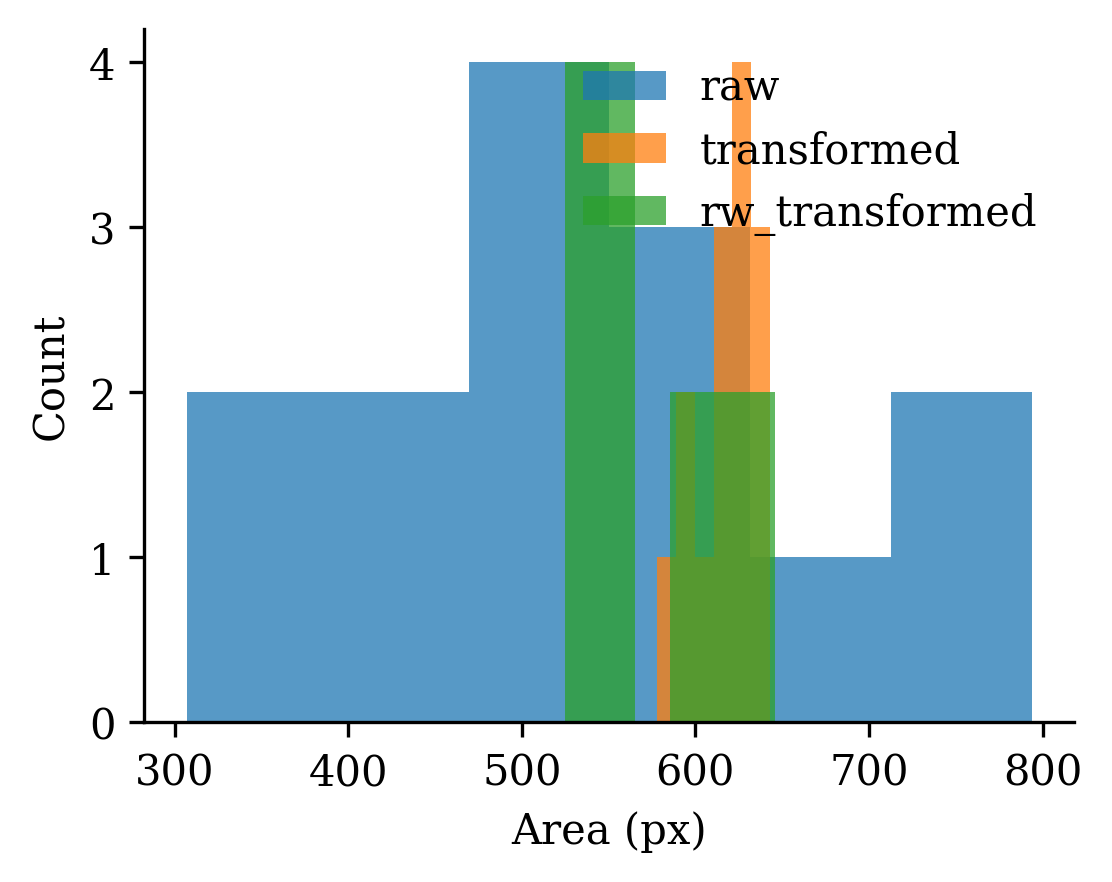

In [34]:
fig = plt.figure(figsize=(4, 3))
fig.dpi = 150
ax = sns.histplot(areas['raw'], label='raw', bins=6, element='step', lw=0, alpha=0.75)
ax = sns.histplot(areas['transformed'], label='transformed', bins=6, element='step', lw=0, alpha=0.75)
ax = sns.histplot(areas['rw_transformed'], label='rw_transformed', bins=6, element='step', lw=0, alpha=0.75)
ax.set(xlabel='Area (px)')
plt.legend(frameon=False)
sns.despine()

## Linear model to compare dynamics between raw and transformed data

In [3]:
import re
from toolz import compose
from aging.size_norm.lightning import predict
from aging.size_norm.data import Session

In [4]:
pattern = re.compile(r'val_loss=(\d\.\d{2}e-\d{2})\.ckpt')
models = sorted(Path('/n/groups/datta/win/longtogeny/size_norm/models/param_scan').glob('**/*.ckpt'))

In [5]:
get_loss = compose(float, lambda x: pattern.search(x).group(1), str)
losses = list(map(get_loss, models))

In [6]:
mdl_list = sorted(zip(models, losses), key=lambda x: x[1])

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [48]:
max_frames = 3_000

val_data_path = Path(
    "/n/groups/datta/win/longtogeny/data/size_network/female_ontogeny_validation.h5"
)

results = []

for model_path, loss in tqdm(mdl_list[:50:2], desc='models'):
    model = SizeNormModel.load_from_checkpoint(model_path, map_location=torch.device(device))
    model.eval()
    model.freeze()

    with h5py.File(val_data_path, "r") as h5f, torch.no_grad():
        for key in tqdm(list(h5f["data"])[::4], desc='animals', leave=False):
            data = np.array([clean(f) for f in h5f["data"][key][:max_frames]])
            preds = predict(Session(data), model, batch_size=512, display=False)

            pipeline = make_pipeline(
                PCA(n_components=10),
                StandardScaler(),
            )

            pcs = pipeline.fit_transform(data.reshape(len(data), -1))

            transformed = PCA(n_components=100).fit_transform(preds.reshape(len(preds), -1))

            mdl = LinearRegression()
            mdl.fit(transformed, pcs)
            score = mdl.score(transformed, pcs)

            pipeline2 = make_pipeline(
                StandardScaler(),
                ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=1500),
            )

            heldout = cross_val_score(pipeline2, transformed, pcs, cv=4)
            results.append(dict(
                animal=key,
                model=model_path,
                fit_score=score,
                heldout_score=heldout.mean(),
            ))

results = pd.DataFrame(results)

models:   0%|          | 0/25 [00:00<?, ?it/s]

animals:   0%|          | 0/4 [00:00<?, ?it/s]

animals:   0%|          | 0/4 [00:00<?, ?it/s]

animals:   0%|          | 0/4 [00:00<?, ?it/s]

animals:   0%|          | 0/4 [00:00<?, ?it/s]

animals:   0%|          | 0/4 [00:00<?, ?it/s]

animals:   0%|          | 0/4 [00:00<?, ?it/s]

animals:   0%|          | 0/4 [00:00<?, ?it/s]

animals:   0%|          | 0/4 [00:00<?, ?it/s]

animals:   0%|          | 0/4 [00:00<?, ?it/s]

animals:   0%|          | 0/4 [00:00<?, ?it/s]

animals:   0%|          | 0/4 [00:00<?, ?it/s]

animals:   0%|          | 0/4 [00:00<?, ?it/s]

animals:   0%|          | 0/4 [00:00<?, ?it/s]

animals:   0%|          | 0/4 [00:00<?, ?it/s]

animals:   0%|          | 0/4 [00:00<?, ?it/s]

animals:   0%|          | 0/4 [00:00<?, ?it/s]

animals:   0%|          | 0/4 [00:00<?, ?it/s]

animals:   0%|          | 0/4 [00:00<?, ?it/s]

animals:   0%|          | 0/4 [00:00<?, ?it/s]

animals:   0%|          | 0/4 [00:00<?, ?it/s]

animals:   0%|          | 0/4 [00:00<?, ?it/s]

animals:   0%|          | 0/4 [00:00<?, ?it/s]

animals:   0%|          | 0/4 [00:00<?, ?it/s]

animals:   0%|          | 0/4 [00:00<?, ?it/s]

animals:   0%|          | 0/4 [00:00<?, ?it/s]

In [49]:
results['loss'] = results['model'].map(get_loss)

In [50]:
best_model = results.groupby('model').mean(numeric_only=True).sort_values(by='heldout_score', ascending=False)

In [51]:
best_model.index[0]

PosixPath('/n/groups/datta/win/longtogeny/size_norm/models/param_scan/7040ec6d-f620-4b40-8168-e5cb09e15f87/UNet-epoch=48-val_loss=5.61e-04.ckpt')

(0.4, 0.75)

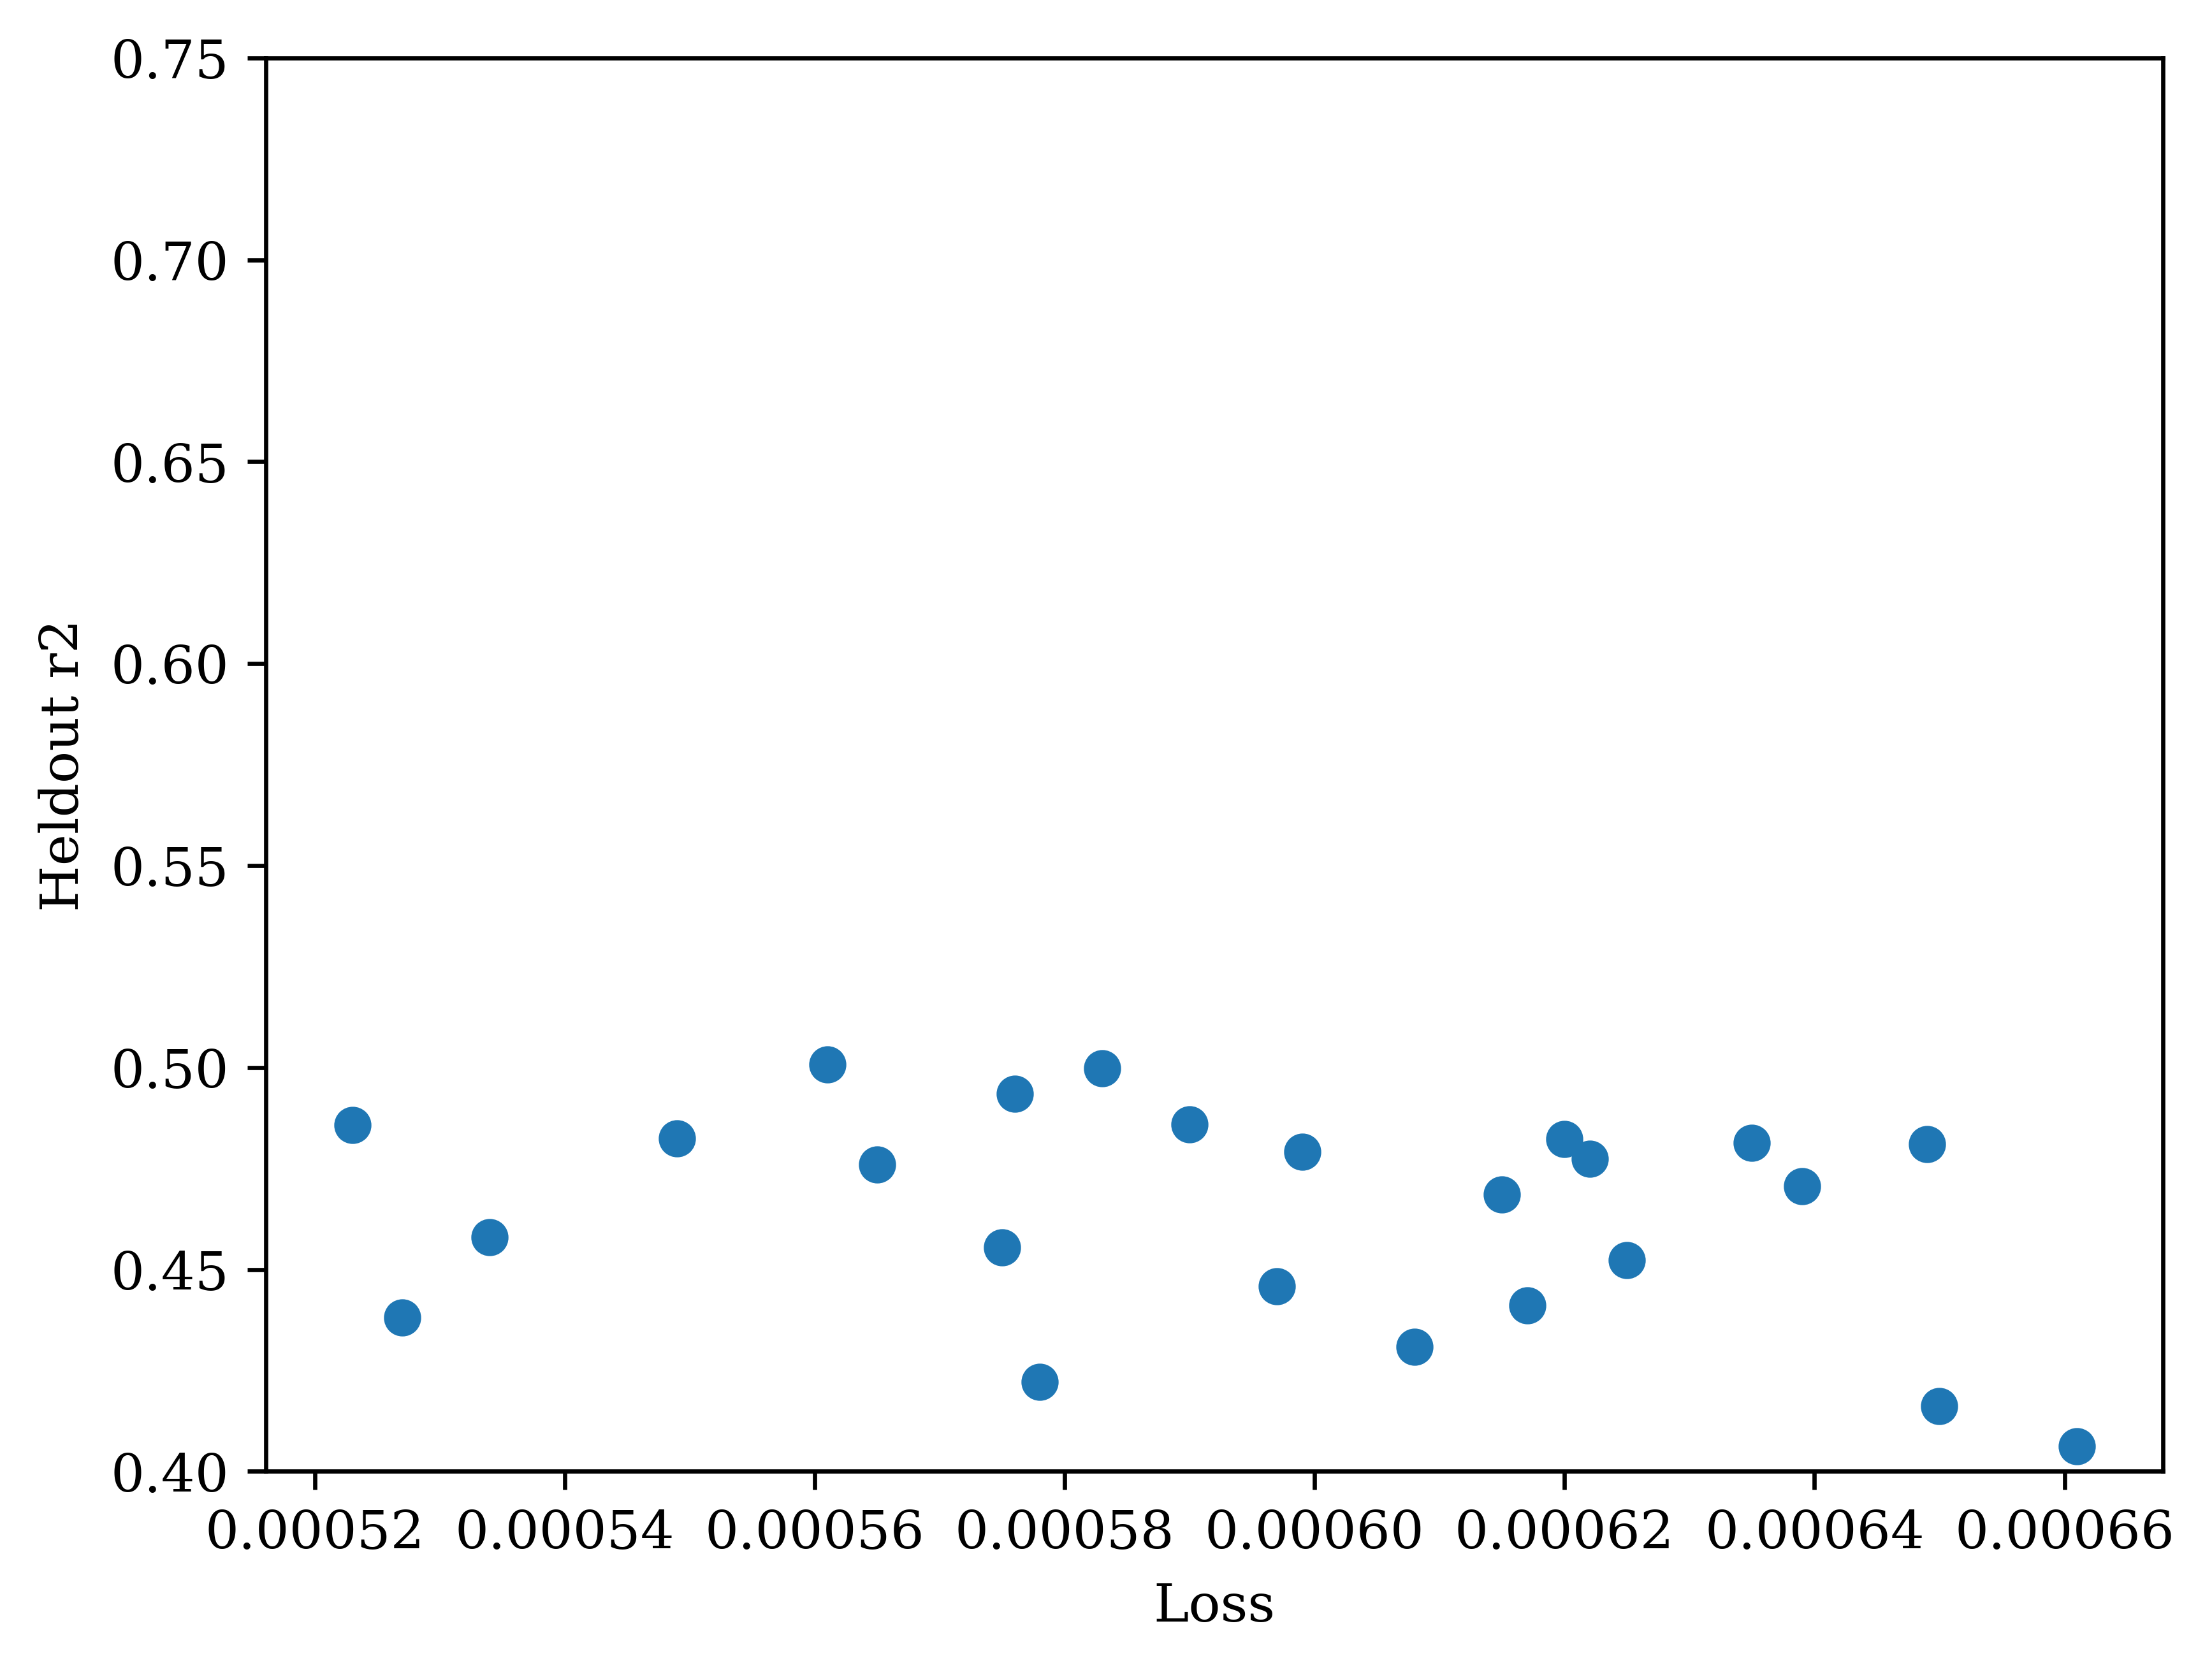

In [52]:
plt.scatter(best_model['loss'], best_model['heldout_score'])
plt.xlabel('Loss')
plt.ylabel('Heldout r2')
plt.ylim(0.4, 0.75)